# Vector DB 저장
 - Vector DB : pinecone, 클라우드 기반

## 환경설정 값 로딩

In [6]:
from dotenv import load_dotenv
import os

load_dotenv(override=True)

True

In [11]:
API_KEY = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.environ['PINECONE_API_KEY']

## Pinecone 클라이언트 초기화

In [12]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key=PINECONE_API_KEY)

## 레코드 업서트 (Upsert)

In [15]:
index = pc.Index("embedding-3d")
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

## index에 벡터 임베딩

In [ ]:
index.upsert(
    vectors=[
        {
            "id": "vec1",
            "values": [1.0, 1.5, 2.0],  # 임베딩 벡터, 행벡터 3차원
            "metadata": {"genre": "drama"}  # 
        }, {
            "id": "vec2",
            "values": [2.0, 1.0, 0.5],
            "metadata": {"genre": "action"}
        }, {
            "id": "vec3",
            "values": [0.1, 0.3, 0.5],
            "metadata": {"genre": "drama"}
        }, {
            "id": "vec4",
            "values": [1.0, 2.5, 3.5],
            "metadata": {"genre": "action"}
        }, {
            "id": "vec5",
            "values": [3.0, 1.2, 1.3],
            "metadata": {"genre": "action"}
        }, {
            "id": "vec6",
            "values": [0.3, 1.1, 2.5],
            "metadata": {"genre": "drama"}
        }
    ],
    namespace="embedding-3d-ns1"  # namespace를 만들면 서칭 속도가 빨라짐 가능
)

{'upserted_count': 6}

## 쿼리하기

In [16]:
response = index.query(
    namespace="embedding-3d-ns1",
    vector=[0.1, 0.3, 0.7],
    top_k=3,
    include_values=True,
    include_metadata=True
)

print(response)

{'matches': [{'id': 'vec6',
              'metadata': {'genre': 'drama'},
              'score': 0.999722,
              'values': [0.3, 1.1, 2.5]},
             {'id': 'vec3',
              'metadata': {'genre': 'drama'},
              'score': 0.990118921,
              'values': [0.1, 0.3, 0.5]},
             {'id': 'vec4',
              'metadata': {'genre': 'action'},
              'score': 0.972905517,
              'values': [1.0, 2.5, 3.5]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 6}}


In [19]:
response = index.query(
    namespace="embedding-3d-ns1",
    vector=[0.1, 0.3, 0.7],
    top_k=3,
    include_values=True,
    include_metadata=True,
    filter={
        "genre" : {"$eq" : "drama"}
    }
)

print(response)

{'matches': [{'id': 'vec6',
              'metadata': {'genre': 'drama'},
              'score': 0.999722,
              'values': [0.3, 1.1, 2.5]},
             {'id': 'vec3',
              'metadata': {'genre': 'drama'},
              'score': 0.990118921,
              'values': [0.1, 0.3, 0.5]},
             {'id': 'vec1',
              'metadata': {'genre': 'drama'},
              'score': 0.942745209,
              'values': [1.0, 1.5, 2.0]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 6}}


In [24]:
for ids in index.list(namespace="embedding-3d-ns1"):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


In [28]:
ids = list(index.list(namespace = "embedding-3d-ns1"))[0]
ids

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']

In [31]:
vectors = index.fetch(ids=ids, namespace="embedding-3d-ns1").vectors
vectors

{'vec4': Vector(id='vec4', values=[1.0, 2.5, 3.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec6': Vector(id='vec6', values=[0.3, 1.1, 2.5], metadata={'genre': 'drama'}, sparse_values=None),
 'vec2': Vector(id='vec2', values=[2.0, 1.0, 0.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec5': Vector(id='vec5', values=[3.0, 1.2, 1.3], metadata={'genre': 'action'}, sparse_values=None),
 'vec3': Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None),
 'vec1': Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None)}

## 3차원 공간에 시각화

In [34]:
ids = [v['id'] for v in vectors.values()]
values = [v['values'] for v in vectors.values()]

ids += ["qv"]
values += [[0.1, 0.3, 0.7]]

print(ids)
print(values)

['vec4', 'vec6', 'vec2', 'vec5', 'vec3', 'vec1', 'qv']
[[1.0, 2.5, 3.5], [0.3, 1.1, 2.5], [2.0, 1.0, 0.5], [3.0, 1.2, 1.3], [0.1, 0.3, 0.5], [1.0, 1.5, 2.0], [0.1, 0.3, 0.7]]


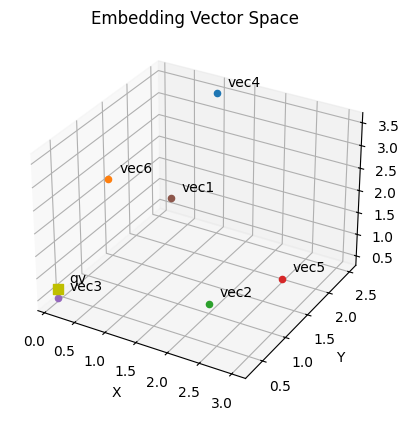

In [35]:
import matplotlib.pyplot as plt

# 3D 플롯을 생성합니다.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 벡터의 ID와 값을 사용하여 3D 공간에 점을 그립니다.
for i, id in enumerate(ids):
    if id == "qv":
        # 쿼리 벡터는 노란색 사각형으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id, color='y', s=50, marker='s')
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)
    else:
        # 나머지 벡터는 기본 색상으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id)
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)

# 축 레이블과 제목을 설정합니다.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Embedding Vector Space')

# 플롯을 표시합니다.
plt.show()

## 인덱스 생성과 삭제
### 인덱스 삭제

In [36]:
index_name = "embedding-3d"

# Pinecone에 있는 모든 인덱스를 순회합니다.
for idx in pc.list_indexes():
    # 인덱스 이름이 "quickstart"와 일치하는 경우 해당 인덱스를 삭제합니다.
    if idx.name == index_name:
        pc.delete_index(idx.name)

### 인덱스 생성

In [ ]:
index_name = "quickstart"
pc.create_index(
    name=index_name,
    dimension=1024, # 모델 차원, embedding model과 일치해야 함
    metric="cosine",
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

{
    "name": "quickstart",
    "metric": "cosine",
    "host": "quickstart-voqt390.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 1024,
    "deletion_protection": "disabled",
    "tags": null
}

In [38]:
pc.list_indexes()

[
    {
        "name": "quickstart",
        "metric": "cosine",
        "host": "quickstart-voqt390.svc.aped-4627-b74a.pinecone.io",
        "spec": {
            "serverless": {
                "cloud": "aws",
                "region": "us-east-1"
            }
        },
        "status": {
            "ready": true,
            "state": "Ready"
        },
        "vector_type": "dense",
        "dimension": 1024,
        "deletion_protection": "disabled",
        "tags": null
    }
]

## embedding vector 생성

In [39]:
data = [
    {"id": "vec1", "text": "사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다."},
    {"id": "vec2", "text": "애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다."},
    {"id": "vec3", "text": "많은 사람들이 건강한 간식으로 사과를 즐겨 먹습니다."},
    {"id": "vec4", "text": "애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다."},
    {"id": "vec5", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},
    {"id": "vec6", "text": "애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다."}
]

embeddings = pc.inference.embed(
    model="multilingual-e5-large",
    inputs=[d['text'] for d in data],
    parameters={
        "input_type": "passage"
    }
)

print(embeddings[0])

{'vector_type': dense, 'values': [0.0301055908203125, -0.0205841064453125, ..., -0.0302276611328125, 0.0241241455078125]}


In [40]:
print(embeddings[0]['values'])
print(len(embeddings[0]['values']))

[0.0301055908203125, -0.0205841064453125, 0.008514404296875, -0.03240966796875, 0.03179931640625, -0.04107666015625, 0.001018524169921875, 0.0736083984375, 0.0265655517578125, -0.0278472900390625, 0.05755615234375, 0.004856109619140625, -0.0255126953125, 0.007617950439453125, -0.0056304931640625, -0.005767822265625, -0.045440673828125, -0.001613616943359375, -0.0051727294921875, -0.007358551025390625, 0.0134124755859375, -0.0007510185241699219, -0.05084228515625, 0.0050201416015625, -0.007541656494140625, -0.0140380859375, -0.0276031494140625, -0.028045654296875, -0.0258636474609375, -0.044158935546875, -0.0250091552734375, -0.003803253173828125, -0.029937744140625, -0.06378173828125, -0.006084442138671875, 0.04193115234375, 0.0166473388671875, 0.017120361328125, -0.0238037109375, 0.0098114013671875, -0.0219268798828125, 0.06219482421875, -0.01190185546875, -0.0186767578125, -0.009124755859375, 0.028411865234375, 0.030548095703125, 0.0013227462768554688, -0.0309906005859375, 0.02929687

## 파인콘에 upsert하기 위한 준비

In [41]:
import time

# 인덱스가 준비될 때까지 대기합니다.
while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

# 인덱스를 초기화합니다.
index_name = "quickstart"
index = pc.Index(index_name)

In [42]:
vectors = []
for meta, emb in zip(data, embeddings):
    vectors.append({
        "id": meta['id'],
        "values": emb['values'],
        "metadata": {'text': meta['text']}
    })

vectors

[{'id': 'vec1',
  'values': [0.0301055908203125,
   -0.0205841064453125,
   0.008514404296875,
   -0.03240966796875,
   0.03179931640625,
   -0.04107666015625,
   0.001018524169921875,
   0.0736083984375,
   0.0265655517578125,
   -0.0278472900390625,
   0.05755615234375,
   0.004856109619140625,
   -0.0255126953125,
   0.007617950439453125,
   -0.0056304931640625,
   -0.005767822265625,
   -0.045440673828125,
   -0.001613616943359375,
   -0.0051727294921875,
   -0.007358551025390625,
   0.0134124755859375,
   -0.0007510185241699219,
   -0.05084228515625,
   0.0050201416015625,
   -0.007541656494140625,
   -0.0140380859375,
   -0.0276031494140625,
   -0.028045654296875,
   -0.0258636474609375,
   -0.044158935546875,
   -0.0250091552734375,
   -0.003803253173828125,
   -0.029937744140625,
   -0.06378173828125,
   -0.006084442138671875,
   0.04193115234375,
   0.0166473388671875,
   0.017120361328125,
   -0.0238037109375,
   0.0098114013671875,
   -0.0219268798828125,
   0.06219482421875

In [43]:
index.upsert(
    vectors=vectors,
    namespace="quickstart_ns1"
)

{'upserted_count': 6}

In [44]:
print(index.describe_index_stats(namespace="quickstart_ns1"))

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'quickstart_ns1': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}


## 쿼리 (Query) 1
 - 사용자 질문을 받아서, embedding vector로 생성하기
### 쿼리 벡터 생성

In [45]:
query = "애플이라는 기술 회사에 대해 알려주세요."

In [47]:
# 쿼리 텍스트를 임베딩 벡터로 변환합니다.
embedding = pc.inference.embed(
    model="multilingual-e5-large",  # ms 오픈 소스, 1024 차원
    inputs=[query],
    parameters={
        "input_type": "query"  # 입력 타입을 쿼리로 설정합니다.
    }
)

print(embedding)
print("="*30)
# embedding[0], embedding.data[0] 두 표현은 결과가 동일하게 나옴
print(embedding[0])
print(embedding.data[0])
print("="*30)
print(len(embedding[0]['values']))

EmbeddingsList(
  model='multilingual-e5-large',
  vector_type='dense',
  data=[
    {'vector_type': dense, 'values': [0.0113525390625, -0.0175933837890625, ..., -0.02020263671875, -0.00698089599609375]}
  ],
  usage={'total_tokens': 14}
)
{'vector_type': dense, 'values': [0.0113525390625, -0.0175933837890625, ..., -0.02020263671875, -0.00698089599609375]}
{'vector_type': dense, 'values': [0.0113525390625, -0.0175933837890625, ..., -0.02020263671875, -0.00698089599609375]}
1024


### 유사 벡터 검색을 위한 쿼리 실행

In [48]:
results = index.query(
    namespace="quickstart_ns1",
    vector=embedding[0].values,  # query 벡터
    top_k=3,
    include_values=False,   # value는 제외
    include_metadata=True
)

# 검색 결과를 출력합니다.
print(results)

{'matches': [{'id': 'vec2',
              'metadata': {'text': '애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다.'},
              'score': 0.897184372,
              'values': []},
             {'id': 'vec4',
              'metadata': {'text': '애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 '
                                   '혁신했습니다.'},
              'score': 0.883859813,
              'values': []},
             {'id': 'vec6',
              'metadata': {'text': '애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, '
                                   '로널드 웨인에 의해 파트너십으로 설립되었습니다.'},
              'score': 0.867899835,
              'values': []}],
 'namespace': 'quickstart_ns1',
 'usage': {'read_units': 1}}


## 쿼리 (Query) 2

In [54]:
# 쿼리 텍스트를 정의합니다.
query = "사과라는 기술 회사에 대해 알려주세요."

# 쿼리 텍스트를 임베딩 벡터로 변환합니다.
embedding = pc.inference.embed(
    model="multilingual-e5-large",
    inputs=[query],
    parameters={
        "input_type": "query"  # 입력 타입을 쿼리로 설정합니다.
    }
)

# 첫 번째 임베딩 벡터를 출력합니다.
print(embedding[0])

{'vector_type': dense, 'values': [-0.016021728515625, -0.0101470947265625, ..., -0.0369873046875, 0.012481689453125]}


In [55]:
results = index.query(
    namespace="quickstart_ns1",
    vector=embedding[0].values,  # query 벡터
    top_k=3,
    include_values=False,   # value는 제외
    include_metadata=True
)

# 검색 결과를 출력합니다.
print(results)

{'matches': [{'id': 'vec2',
              'metadata': {'text': '애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다.'},
              'score': 0.82978791,
              'values': []},
             {'id': 'vec5',
              'metadata': {'text': '하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다.'},
              'score': 0.821688294,
              'values': []},
             {'id': 'vec1',
              'metadata': {'text': '사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다.'},
              'score': 0.821254432,
              'values': []}],
 'namespace': 'quickstart_ns1',
 'usage': {'read_units': 6}}


## 쿼리 (Query) 3
### 질문 인코딩 (embedding vector로 변환)

In [52]:
# 쿼리 텍스트를 정의합니다.
query = "애플(사과)라는 기술 회사에 대해 알려주세요."

# 쿼리 텍스트를 임베딩 벡터로 변환합니다.
embedding = pc.inference.embed(
    model="multilingual-e5-large",  
    inputs=[query],
    parameters={
        "input_type": "query"  # 입력 타입을 쿼리로 설정합니다.
    }
)

# 첫 번째 임베딩 벡터를 출력합니다.
print(embedding[0])

{'vector_type': dense, 'values': [-0.00445556640625, -0.021484375, ..., -0.0186614990234375, 0.0077972412109375]}


### 유사도 높은 top 3 검색 실행

In [53]:
# ns1 네임스페이스에서 쿼리 벡터와 유사한 상위 3개의 벡터를 검색합니다.
# 검색 결과에는 벡터 값은 포함되지 않고 메타데이터만 포함됩니다.
results = index.query(
    namespace="quickstart_ns1",
    vector=embedding[0].values,  # query 벡터
    top_k=3,
    include_values=False,   # value는 제외
    include_metadata=True
)

# 검색 결과를 출력합니다.
print(results)

{'matches': [{'id': 'vec2',
              'metadata': {'text': '애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다.'},
              'score': 0.882141769,
              'values': []},
             {'id': 'vec4',
              'metadata': {'text': '애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 '
                                   '혁신했습니다.'},
              'score': 0.872143626,
              'values': []},
             {'id': 'vec6',
              'metadata': {'text': '애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, '
                                   '로널드 웨인에 의해 파트너십으로 설립되었습니다.'},
              'score': 0.855100691,
              'values': []}],
 'namespace': 'quickstart_ns1',
 'usage': {'read_units': 6}}
